In [237]:
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randrange, uniform
import soundfile

In [238]:
FS = 44100
LEN = 10 * FS

In [239]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def sigmoid_fade(data, fade_length):
    n = np.arange(0, fade_length)
    n -= int(fade_length / 2)
    fade_in = [sigmoid(x / (fade_length / 12)) for x in n]
    fade_out = np.flip(fade_in)
    ones = np.ones(len(data) - 2 * fade_length)
    fade = np.concatenate((fade_in, ones, fade_out))
    faded_data = fade * data
    return faded_data

class EnvelopeGenerator:
    def __init__(self, l):
        self.l = l
        self.n = np.arange(0, self.l)

    def allpass(self):
        allpass_env = np.ones(self.l)
        allpass_env = sigmoid_fade(allpass_env, int(self.l / 200))
        return allpass_env

    def fadein(self):
        n = self.n - int(self.l / 2)
        fadein_env = [sigmoid(x / (self.l  / 12)) for x in n]
        fadein_env = sigmoid_fade(fadein_env, int(self.l / 200))
        return fadein_env

    def fadeout(self):
        n = self.n - int(self.l / 2)
        fadein_env = [sigmoid(x / (self.l  / 12)) for x in n]
        fadeout_env = np.flip(fadein_env)
        fadeout_env = sigmoid_fade(fadeout_env, int(self.l / 200))
        return fadeout_env

    def single_perc(self):
        perc_env = 0.005 ** np.linspace(0, 1, self.l)
        perc_env = sigmoid_fade(perc_env, int(self.l / 200))
        return perc_env

    def single_cos(self):
        cos_env = np.cos(np.linspace(0, 2 * np.pi, self.l)) + 1
        cos_env /= max(abs(cos_env))
        cos_env = 1 - cos_env
        return cos_env

    def multi_perc(self, number):
        cutpoints = [self.l]
        for i in range(number):
            cutpoints.append(int(i * (self.l / number)))
        cutpoints.sort()

        multi_perc_env = []
        for i in range(len(cutpoints) - 1):
            perc_len = cutpoints[i + 1] - cutpoints[i]
            perc_env = 0.0005 ** np.linspace(0, 1, perc_len)
            perc_env = sigmoid_fade(perc_env, int(perc_len / 200))
            multi_perc_env.append(perc_env)

        multi_perc_env_flat = [x for sublist in multi_perc_env for x in sublist]

        return multi_perc_env_flat

    def multi_cos(self, number):
        cutpoints = [self.l]
        for i in range(number):
            cutpoints.append(int(i * (self.l / number)))
        cutpoints.sort()

        multi_cos_env = []
        for i in range(len(cutpoints) - 1):
            cos_len = cutpoints[i + 1] - cutpoints[i]
            cos_env = np.cos(np.linspace(0, 2 * np.pi, cos_len)) + 1
            cos_env /= max(abs(cos_env))
            cos_env = 1 - cos_env
            multi_cos_env.append(cos_env)

        multi_cos_env_flat = [x for sublist in multi_cos_env for x in sublist]
        
        return multi_cos_env_flat

    def get_all(self, n_multi_perc, n_multi_cos):
        envelopes = [
            self.allpass(),
            self.fadein(),
            self.fadeout(),
            self.single_perc(),
            self.single_cos(),
            self.multi_perc(n_multi_perc),
            self.multi_cos(n_multi_cos)
        ]
        return envelopes

def generate_signals(carrier, envelopes):
    signals = []
    for e in envelopes:
        signal = carrier * e
        signals.append(signal)
    return signals

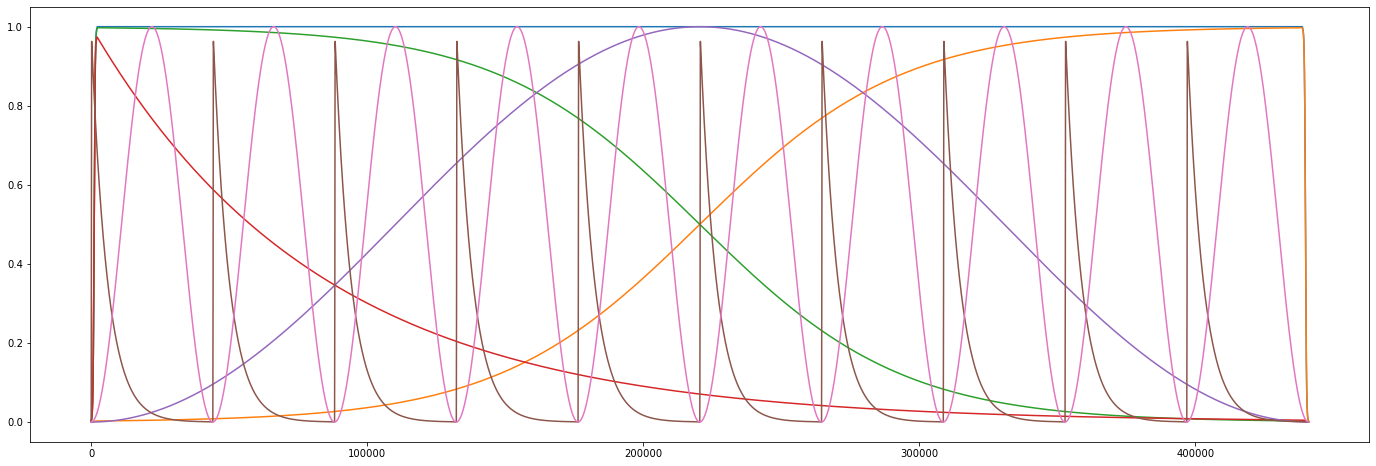

In [240]:
env_gen = EnvelopeGenerator(LEN)
envelopes = env_gen.get_all(10, 10)

plt.figure(figsize=(24, 8))
for e in envelopes:
    plt.plot(e)
plt.show()

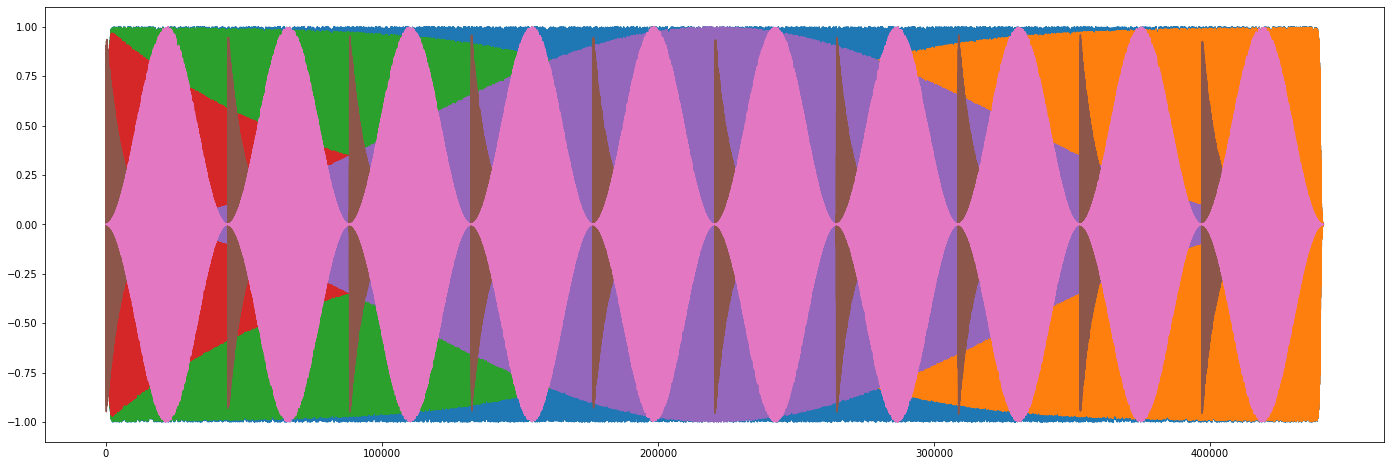

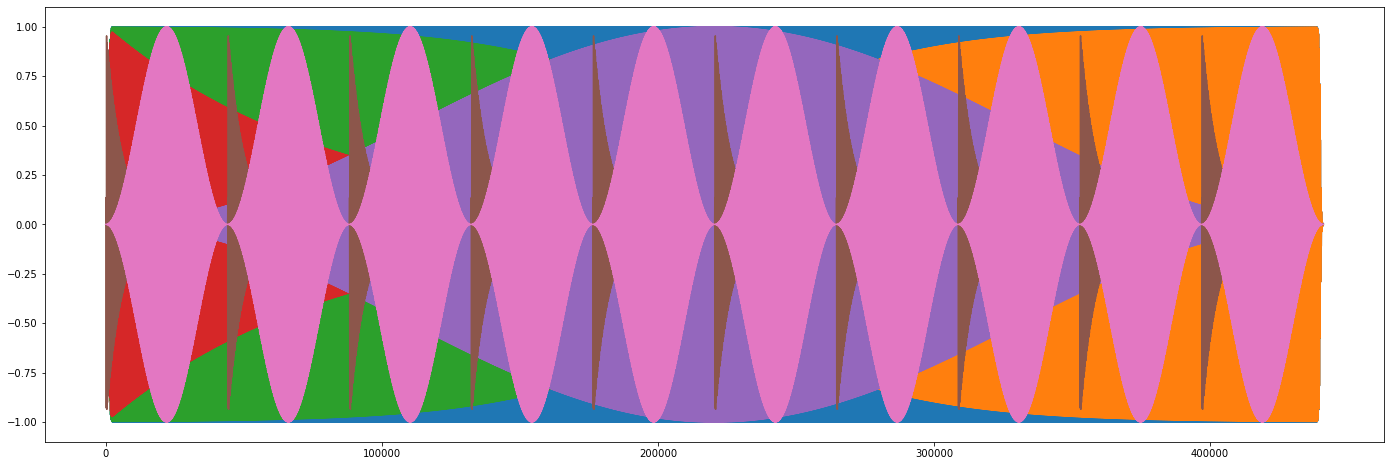

In [241]:
noise = np.random.rand(LEN) * 2 - 1
noise_signals = generate_signals(noise, envelopes)

sine = np.sin(2 * np.pi * 200 * np.arange(0, LEN) / FS)
sine_signals = generate_signals(sine, envelopes)

plt.figure(figsize=(24, 8))
for n in noise_signals:
    plt.plot(n)
plt.show()

plt.figure(figsize=(24, 8))
for s in sine_signals:
    plt.plot(s)
plt.show()

In [242]:
for i in range(len(noise_signals)):
    soundfile.write(f'./audio-output/noise_{i}.wav', noise_signals[i], FS)
    soundfile.write(f'./audio-output/sine_{i}.wav', sine_signals[i], FS)